# Active thermal cooling test case

#### *Paper*:        Real-time optimal control of high-dimensional parametrized systems by deep learning-based reduced order models
#### *Authors*:      M.Tomasetto, F.Braghin, A.Manzoni
#### *Affiliations*: Department of Mechanical Engineering (Politecnico di Milano), MOX - Department of Mathematics (Politecnico di Milano)

In [1]:
#IMPORT LIBRARIES

from dolfin import *
from dolfin_adjoint import *
import gmsh
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from IPython.display import clear_output as clc

from dlroms.cores import CPU, GPU # Cores swapping
import dlroms.fespaces as fe # Finite element spaces handling
import dlroms.geometry as geo # Mesh creation
from dlroms.roms import num2p # Percentage format

import seaborn as sns
teal = sns.light_palette("teal", 15)
magenta = sns.dark_palette("magenta", 15)
red = sns.light_palette("orangered", 15)
navy = sns.light_palette("navy", 15)

set_log_level(LogLevel.ERROR)

# State problem
 Steady heat equation
$$
\begin{equation}
    \begin{cases}
       - \mu \Delta q = s(\boldsymbol{\mu}_s) + u{1}_{\Omega_c}  \qquad &\mathrm{in} \ \Omega \\
       - \mu \nabla q \mathbf{n} = q  \qquad &\mathrm{on} \ \Gamma_{\mathrm{d}} \\
        - \mu \nabla q \mathbf{n} = h (q - q_{\mathrm{ext}})  \qquad &\mathrm{on} \ \Gamma_{\mathrm{obs}}
\end{cases}
\end{equation}
$$

where $\Omega$ is the domain of interest, $q: \Omega \to \mathbb R$ is the unknown temperature field, $u: \Omega_c \to \mathbb R$ is the control variable that specifies the source term in the annular region around the obstacle $\Omega_c$, $s: \Omega \to \mathbb R$ is the external source term depending on scenario parameters $\boldsymbol{\mu}_s$, $\mu$ is the thermal diffusivity, $h$ is the heat transfer coefficient, $q_{\mathrm{ext}}$ is the environment temperature, $\mathbf{n}$ is the normal versor

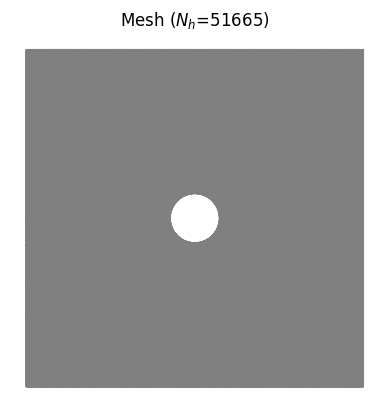

In [2]:
# CREATE THE MESH FOR THE STATE PROBLEM

domain = geo.Rectangle((-1,-1),(1,1)) - geo.Circle((0.0, 0.0), 0.15)
mesh = geo.mesh(domain, stepsize = 0.01)

# Refine the mesh in the control region
class OmegaC(SubDomain): # Control region
    def inside(self, x, on_boundary):
        return x[0]*x[0] + x[1]*x[1] > 0.2 * 0.2 and x[0]*x[0] + x[1]*x[1] < 0.3 * 0.3
domains_bool = MeshFunction("bool", mesh, mesh.geometric_dimension())
domains_bool.set_all(False)
OmegaC().mark(domains_bool, True)
mesh = refine(mesh, domains_bool)

plot(mesh)
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices());
plt.axis('off');

In [3]:
# DEFINE AND MARK SUBDOMAINS AND BOUNDARY PORTIONS

domains = MeshFunction("size_t", mesh, mesh.geometric_dimension())
OmegaC().mark(domains, 1)
dx = Measure("dx", domain = mesh, subdomain_data = domains) # Domain measure

class GammaD(SubDomain): # External boundary
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], -1.0) or near(x[0], 1.0) or near(x[1], -1.0) or near(x[1], 1.0))
class GammaOBS(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        d = sqrt(x[0]*x[0] + x[1]*x[1])
        return on_boundary and d <= 0.15 + DOLFIN_EPS
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
GammaD().mark(boundaries, 1)
GammaOBS().mark(boundaries, 2)
ds = Measure("ds", domain = mesh, subdomain_data = boundaries) # Boundary measure

In [4]:
# DEFINE THE SPACE STATE

space = fe.space(mesh, 'CG', 1) # State space
clc()

nh = space.dim() # State space dimension

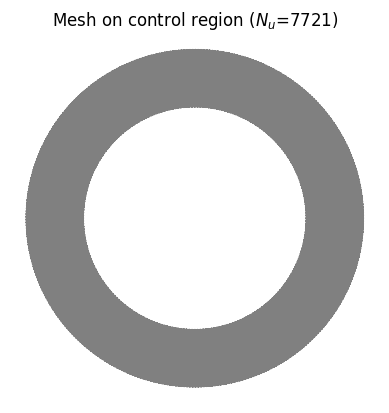

In [5]:
# DEFINE MESH ON CONTROL REGION

domain_control = geo.Circle((0.0, 0.0), 0.3) - geo.Circle((0.0, 0.0), 0.2)
mesh_control = geo.mesh(domain_control, stepsize = 0.005)
space_control = fe.space(mesh_control, 'CG', 1)
dx_control = Measure("dx", domain = mesh_control) # Control region measure

nu = space_control.dim() # Control region dimension

plot(mesh_control)
plt.title("Mesh on control region ($N_{u}$=%d)" % mesh_control.num_vertices());
plt.axis("off");

In [6]:
# GET THE BOUNDARY INDICES

idx_obstacle = fe.boundary(mesh, space, GammaOBS())
nobs = len(idx_obstacle)

In [7]:
# DEFINE THE STATE PROBLEM SOLVER

mu = 1.0

def compute_state(param, u):
    """
    Solve the steady heat equation
    Input: scenario parameters, i.e. the coordinates of the source, and control function
    Output: state function     
    """
    # Solve state equation
    int_source = 5000.0
    var_source = 0.025
    theta_source = param[0]
    r_source = param[1]
    x_source = r_source * cos(theta_source)
    y_source = r_source * sin(theta_source)
    q_ext = int_source * var_source
    h = 1.0 # (heat transfer coefficient) * (volumetric heat capacity)
    
    s = Expression('int_source * exp(-((x[0] - x_source)*(x[0] - x_source) + (x[1] - y_source)*(x[1] - y_source)) / var_source)', degree = 1, int_source = int_source, x_source = x_source, y_source = y_source, var_source = var_source)
    
    q = TrialFunction(space)
    v = TestFunction(space)
    u.set_allow_extrapolation(True)
       
    a = mu * inner(grad(q), grad(v)) * dx + inner(q, v) * ds(1) + h * inner(q, v) * ds(2) 
    L = s * v * dx + u * v * dx(1) + h * q_ext * v * ds(2)
    
    q = Function(space)
    solve(a == L, q)
    
    return q

Mean temperature on the obstacle boundary: 90.13807061292516


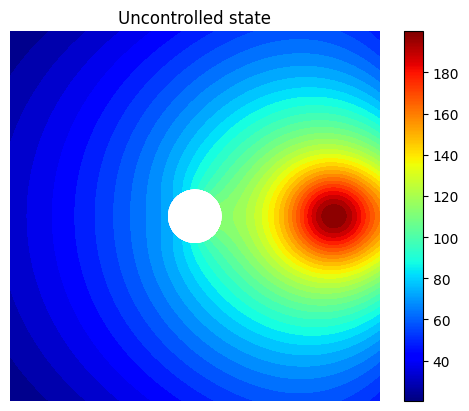

In [8]:
# SOLVE THE STATE PROBLEM

u = interpolate(Expression('0.0', degree = 1), space_control)

q = compute_state([0.0, 0.75], u = u)

print(f"Mean temperature on the obstacle boundary: {q.vector()[idx_obstacle].mean()}")

fig_dummy = plot(q, mode = "color", cmap = "jet")
fig = plot(q, cmap = "jet")
plt.colorbar(fig_dummy)
plt.title("Uncontrolled state");
plt.axis('off');

In [9]:
# DEFINE A FUNCTION TO PLOT THE OBSTACLE TEMPERATURE VALUES

def plot_qOBS(q, q_opt = None):
    """
    Plot the temperature values on the obstacle boundary. If two inputs are given, two temperature profiles are compared. 
    """
    
    vals = [q(0.15 * cos(a), 0.15 * sin(a)) for a in np.linspace(0, 2*pi, 200)]
    plt.plot([a for a in np.linspace(0, 2*pi, 200)], vals, label = "$q_{\mathrm{obs}}$", color = teal[14], linewidth = 3)
    
    if(q_opt != None):
        vals_opt = [q_opt(0.15 * cos(a), 0.15 * sin(a)) for a in np.linspace(0, 2*pi, 200)]
        plt.plot([a for a in np.linspace(0, 2*pi, 200)], vals_opt, label = "$q^*_{\mathrm{obs}}$", color = magenta[5], linewidth = 3)

    plt.plot([a for a in np.linspace(0, 2*pi, 200)], CPU.zeros(len(vals)), '--', linewidth = 1, color = "darkgray", label = "$q = 0.0$")
    plt.legend(loc = "best", fontsize=12)
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$q$", fontsize=15)
    plt.title("Temperature on obstacle boundary");

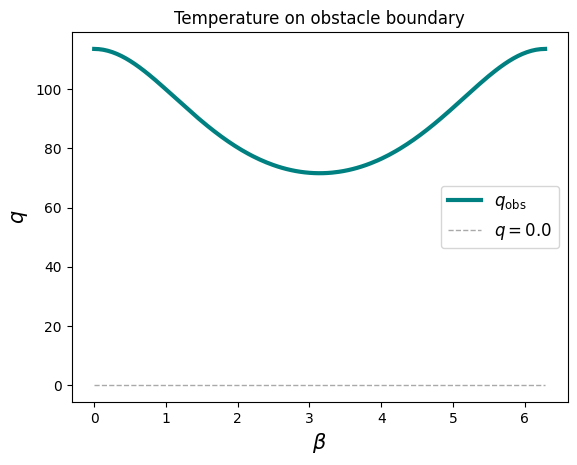

In [10]:
# UNCONTROLLED OBSTACLE TEMPERATURES (PLOT)

plot_qOBS(q)

# Optimization with FOM

In [11]:
# SOLVE THE OPTIMAL CONTROL PROBLEM

theta_source = 0.0
r_source = 0.75
beta = 0.0000001
beta_g = 0.0000001

set_working_tape(Tape()) # Reset forward model annotated by dolfin adjoint

u = interpolate(Expression('0.0', degree = 1), space)

q = compute_state([theta_source, r_source], u)

J = assemble(0.5 * inner(q, q) * ds(2) +  0.5 * beta * inner(u,u) * dx(1) +  0.5 * beta_g * inner(grad(u),grad(u)) * dx(1))
control = Control(u)
Jhat = ReducedFunctional(J, control)

u_opt = minimize(Jhat, method ="L-BFGS-B", tol = 1e-10, options = {'disp': True, "maxiter":10000, 'ftol': 1e-10, 'gtol': 1e-10})   
q_opt = compute_state([theta_source, r_source], u_opt)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51665     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86036D+03    |proj g|=  1.14148D-03


 This problem is unconstrained.



At iterate    1    f=  6.28212D+03    |proj g|=  1.02583D-03

At iterate    2    f=  1.41781D+02    |proj g|=  9.88619D-05

At iterate    3    f=  1.14524D+02    |proj g|=  8.39619D-05

At iterate    4    f=  4.64029D+00    |proj g|=  6.05401D-05

At iterate    5    f=  2.69535D+00    |proj g|=  1.52832D-05

At iterate    6    f=  2.31560D+00    |proj g|=  1.33803D-05

At iterate    7    f=  1.27023D+00    |proj g|=  6.32870D-06

At iterate    8    f=  8.22864D-01    |proj g|=  4.11282D-05

At iterate    9    f=  4.43034D-01    |proj g|=  5.69589D-06

At iterate   10    f=  3.29788D-01    |proj g|=  3.99836D-06

At iterate   11    f=  2.39567D-01    |proj g|=  4.64591D-06

At iterate   12    f=  2.13920D-01    |proj g|=  1.52986D-05

At iterate   13    f=  1.76565D-01    |proj g|=  1.61876D-06

At iterate   14    f=  1.68470D-01    |proj g|=  1.42572D-06

At iterate   15    f=  1.62132D-01    |proj g|=  2.89427D-06

At iterate   16    f=  1.56171D-01    |proj g|=  2.01788D-06

At iter

Mean relative error on the obstacle temperature: 0.01%


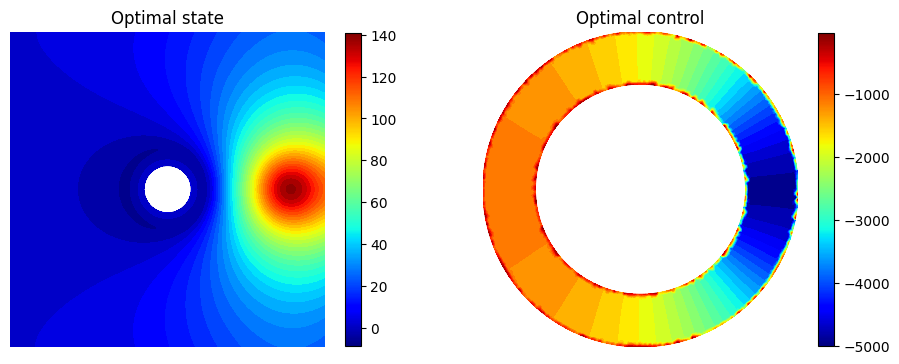

In [12]:
# OPTIMAL PAIR (PLOT)

u_opt_plot = interpolate(u_opt, space_control)
plotlist = [CPU.tensor(q_opt.vector()), CPU.tensor(u_opt_plot.vector())]
fe.multiplot(plotlist, (10, 10), (space, space_control), titles = ("Optimal state", "Optimal control"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

print(f"Mean relative error on the obstacle temperature: {num2p(q_opt.vector()[idx_obstacle].mean())}")

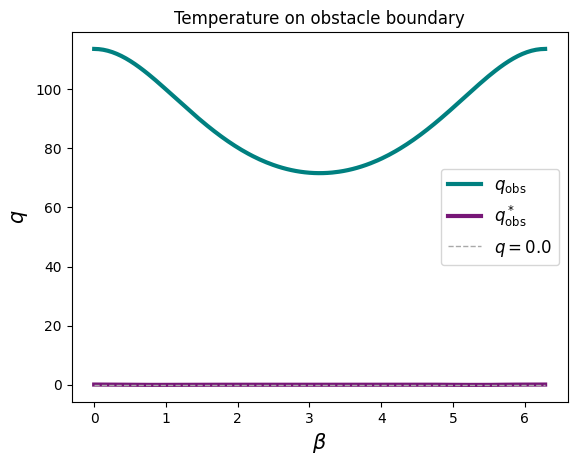

In [13]:
# UNCONTROLLED vs OPTIMAL OBSTACLE TEMPERATURES (PLOT)

plot_qOBS(q, q_opt)

# Snapshots generation

### PDE-constrained Optimisation

Consider the problem of minimising the temperature on the obstacle boundary

$$
\min_{q,u} \int_{\Gamma_{\text{obs}}} |q|^2 + \beta \int_{\Omega_{\textrm{c}}} |u|^2  + \beta_g \int_{\Omega_{\textrm{c}}} ||\nabla u||^2  \\
$$

In [ ]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)
 
from dlroms.ocp import snapshots

nsnapshots = 100
ntrain = 80
nparams = 2

beta = 0.0000001
beta_g = 0.0000001

ranges = [(-pi/2, pi/2), (0.4, 0.9)] # Scenario paramters: theta_source, r_source

set_working_tape(Tape()) # Reset forward model annotated by dolfin adjoint 

def sampler(seed = 0):
    """
    Generate a random sample of scenario parameters and the corresponding optimal pair
    Input: seed
    Output: scenario parameters, optimal state and control
    """
    params = [0] * len(ranges)
    for i in range(len(ranges)):
        params[i] = ((ranges[i][1] - ranges[i][0]) * CPU.rand() + ranges[i][0]).item()    
    
    u = interpolate(Expression('0.0', degree = 1), space) # Control initialization

    q = compute_state(params, u)

    J = assemble(inner(q, q) * ds(2) +  beta * inner(u,u) * dx(1) +  beta_g * inner(grad(u),grad(u)) * dx(1))  
    control = Control(u)
    Jhat = ReducedFunctional(J, control)
    
    u_opt = minimize(Jhat, method ="L-BFGS-B", tol = 1e-10, options = {'disp': True, "maxiter": 1000, 'ftol': 1e-10, 'gtol': 1e-10})
    q_opt = compute_state(params, u_opt)

    set_working_tape(Tape())    
   
    return params, q_opt.vector(), interpolate(u_opt, space_control).vector()

snapshots(nsnapshots, sampler, core = CPU, verbose = True, filename = 'Data/Cooling')

In [13]:
# LOAD SNAPSHOTS MATRICES

nsnapshots = 100
ntrain = 80
nparams = 2

ranges = [(-pi/2, pi/2), (0.4, 0.9)] # Scenario paramters: theta_source, r_source

filename = 'Data/Cooling'
Data = np.load("%s.npz" % filename.replace(".npz",""))

MU = CPU.tensor(Data["mu"])
Q = CPU.tensor(Data["y"])
U = CPU.tensor(Data["u"])

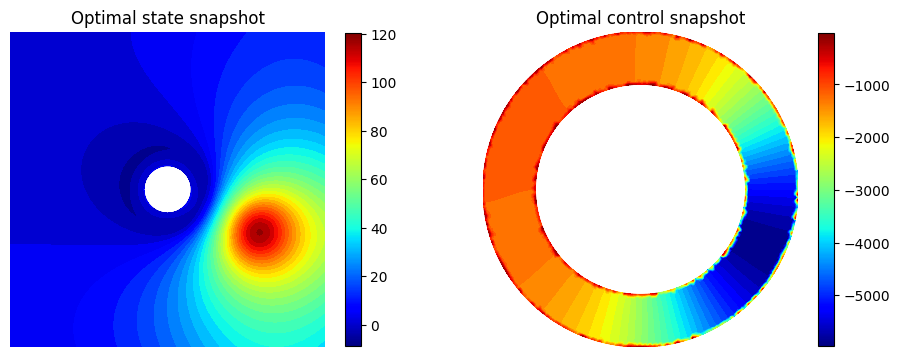

In [14]:
# SNAPSHOT EXAMPLE (PLOT)

which = 0

plotlist = [Q[which], U[which]]
fe.multiplot(plotlist, (10, 10), (space, space_control), titles = ("Optimal state snapshot", "Optimal control snapshot"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

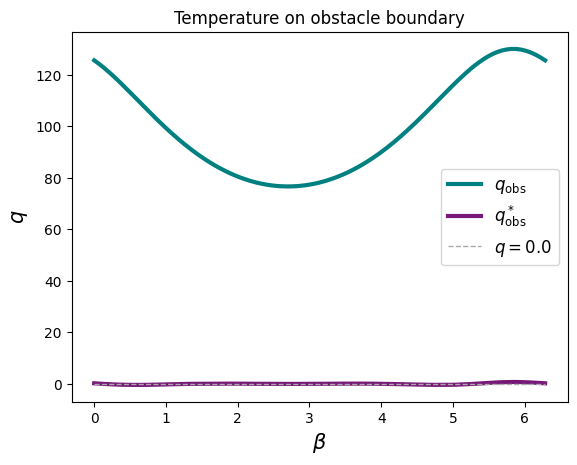

In [15]:
# UNCONTROLLED vs OPTIMAL OBSTACLE TEMPERATURES (PLOT)

which = 0

u = interpolate(Expression('0.0', degree = 1), space_control)
q = compute_state([MU[which,0].item(), MU[which,1].item()], u = u)
plot_qOBS(q, fe.asvector(Q[which], space))

# POD-DL-ROM

In [16]:
# IMPORT FUNCTIONS FOR NEURAL NETWORKS AND ERRORS

from dlroms.dnns import Dense, Weightless # Neural networks handling
from dlroms.roms import projectup, mre, mse, euclidean # Proper orthogonal decomposition
from dlroms.ocp import L2, Linf # Error metrics

l2_state = L2(mesh, space, measure = dx, core = CPU)
l2_control = L2(mesh_control, space_control, measure = dx_control, core = CPU)
linf = Linf()

mse = mse(euclidean)
mre = mre(euclidean)

In [17]:
# DEFINE THE OCP OBJECT TO HANDLE REDUCTIONS AND PREDICTIONS

from dlroms.ocp import OCP

ocp = OCP(ntrain)

## State reduction - POD+AE

In [18]:
# POD+AE

k_Q = 72 # Number of POD modes
n_Q = 6 # Latent dimension
encoder = Dense(k_Q, 70) + Dense(70, 30) + Dense(30, n_Q)
decoder = Dense(n_Q, 30) + Dense(30, 50) + Dense(50, 70) + Dense(70, k_Q, activation = None)

Q_DLROM, Q_reconstructed, pod_Q, eig_Q = ocp.PODAE(Q, k = k_Q, encoder = encoder, decoder = decoder, training = False, save = False, path = 'NN/Cooling/autoencoder.pt', decay = False, epochs = 1000, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [19]:
# POD+AE RECONSTRUCTION ERRORS ON TEST DATA

print("POD+AE reconstruction errors:")
print("")
print("Mean relative error: %s." % num2p(mre(Q[ntrain:], Q_reconstructed[ntrain:])))
print("L2 mean relative error: %s." % num2p(l2_state.mre(Q[ntrain:], Q_reconstructed[ntrain:])))
print("Linf mean relative error: %s." % num2p(linf.mre(Q[ntrain:], Q_reconstructed[ntrain:])))

POD+AE reconstruction errors:

Mean relative error: 2.04%.
L2 mean relative error: 2.00%.
Linf mean relative error: 2.99%.


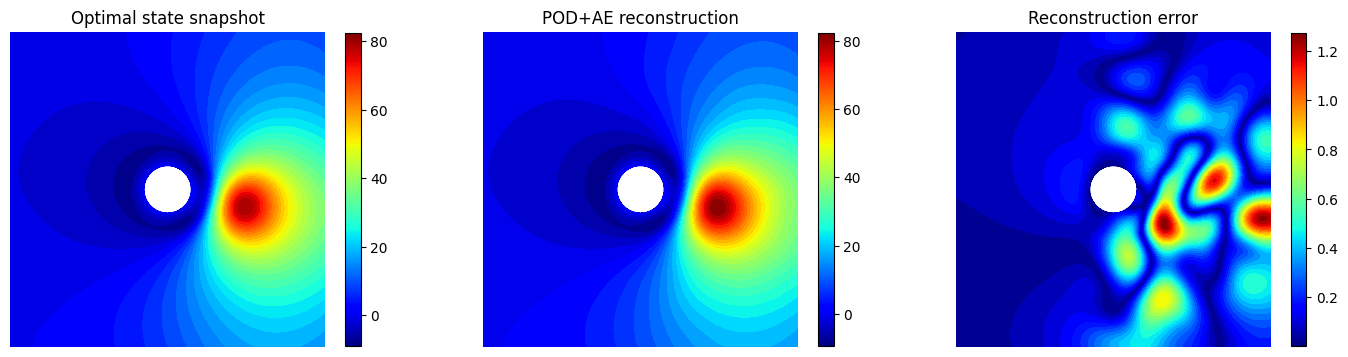

In [20]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

plotlist = [Q[which], Q_reconstructed[which], ((Q[which] - Q_reconstructed[which])**2).sqrt()]
fe.multiplot(plotlist, (10, 10), space, titles = ("Optimal state snapshot", "POD+AE reconstruction", "Reconstruction error"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

## Control reduction - POD

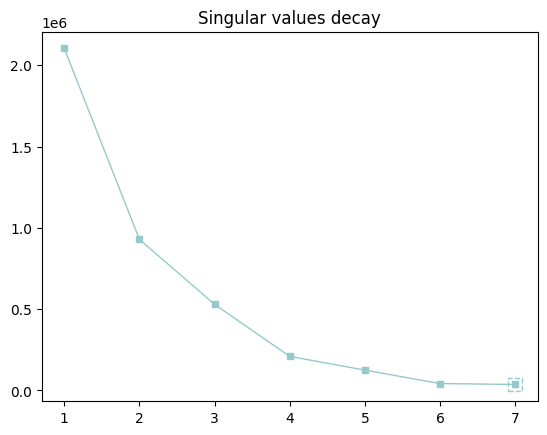

In [21]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR U

n_U = k_U = 7 # Number of POD modes
U_POD, U_reconstructed, pod_U, eig_U = ocp.POD(U, k = k_U, color = teal[5])

In [22]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("POD reconstruction errors:")
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_reconstructed[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre(U[ntrain:], U_reconstructed[ntrain:])))
print("Linf mean relative error on U: %s." % num2p(linf.mre(U[ntrain:], U_reconstructed[ntrain:])))

POD reconstruction errors:

Mean relative error on U: 0.17%.
L2 mean relative error on U: 0.17%.
Linf mean relative error on U: 0.14%.


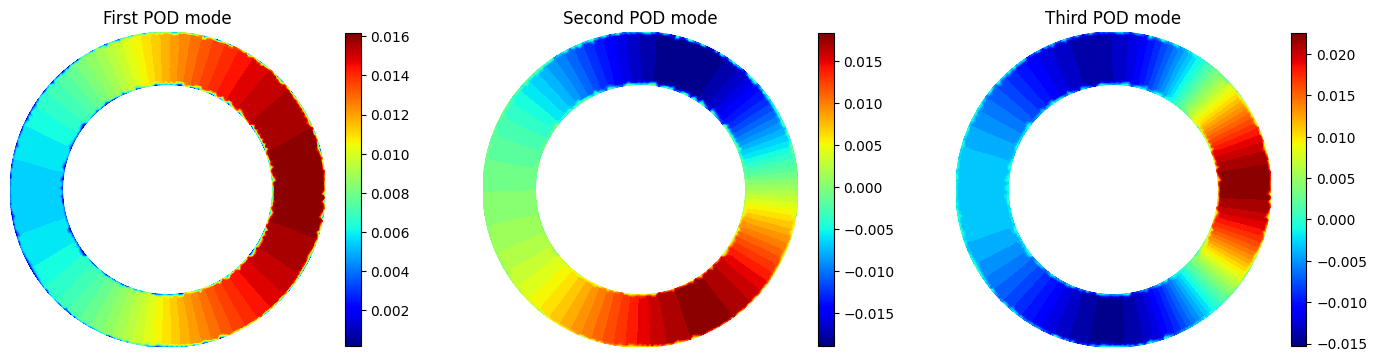

In [23]:
# POD MODES (PLOT)

plotlist = [pod_U[0], pod_U[1], pod_U[2]]
fe.multiplot(plotlist, (10, 10), space_control, titles = ("First POD mode", "Second POD mode", "Third POD mode"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

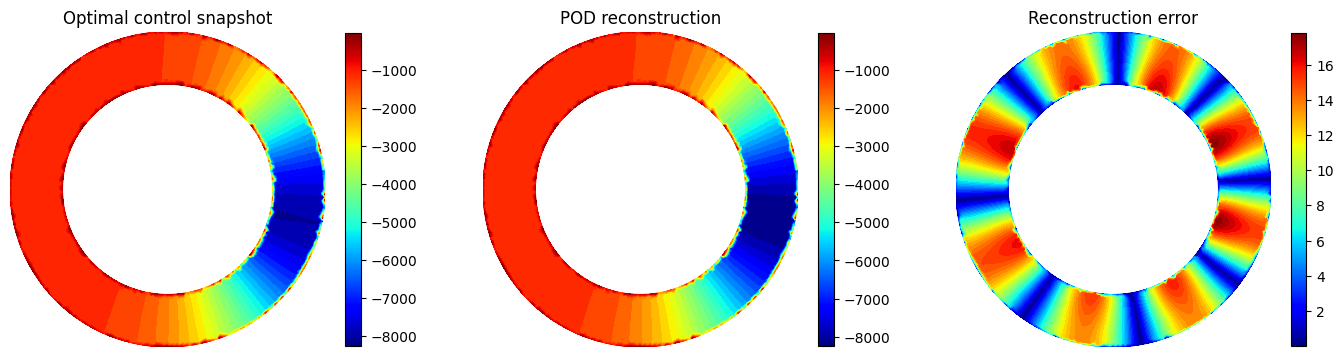

In [24]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plotlist = [U[which], U_reconstructed[which], ((U[which] - U_reconstructed[which])**2).sqrt()]
fe.multiplot(plotlist, (10, 10), space_control, titles = ("Optimal control snapshot", "POD reconstruction", "Reconstruction error"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

## Parameter-to-solution map $\boldsymbol{\mu}_s \to ( \mathbf{u}_{POD}, \mathbf{y}_{POD+AE} )$ 


In [25]:
# NN TO MAP PARAMETERS IN REDUCED OPTIMAL STATE AND CONTROL

class Embedd(Weightless): # First layer with some fixed transformation of the input (driven by the problem)
    def forward(self, x):
        return torch.cat([x, x[:,[0]].cos(), x[:,[1]]*x[:,[0]].cos(), x[:,[0]].sin(), x[:,[1]]*x[:,[0]].sin()], axis = 1)
                         
phi = Embedd() + Dense(6,  50) + Dense(50, 50) + Dense(50, n_Q + n_U, activation = None)

Q_DLROM_hat, U_POD_hat = ocp.redmap(phi, MU, [Q_DLROM, U_POD], minmax = True, training = False, save = False, path = 'NN/Cooling/phi.pt', epochs = 1000, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [26]:
# POD-DL-ROM PREDICTION ERRORS ON TEST DATA

Q_hat = projectup(pod_Q, decoder(Q_DLROM_hat))
U_hat = projectup(pod_U, U_POD_hat)

print("POD-DL-ROM prediction errors:")
print("")
print("Mean relative error on Q: %s." % num2p(mre(Q[ntrain:], Q_hat[ntrain:])))
print("L2 mean relative error on Q: %s." % num2p(l2_state.mre(Q[ntrain:], Q_hat[ntrain:])))
print("Linf mean relative error on Q: %s." % num2p(linf.mre(Q[ntrain:], Q_hat[ntrain:])))
print("")
print("Mean relative error on U: %s." % num2p(mre(U[ntrain:], U_hat[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre(U[ntrain:], U_hat[ntrain:])))
print("Linf mean relative error on U: %s." % num2p(linf.mre(U[ntrain:], U_hat[ntrain:])))

POD-DL-ROM prediction errors:

Mean relative error on Q: 3.90%.
L2 mean relative error on Q: 3.83%.
Linf mean relative error on Q: 5.67%.

Mean relative error on U: 1.10%.
L2 mean relative error on U: 1.10%.
Linf mean relative error on U: 1.22%.


In [27]:
# OBSTACLE TEMPERATURE ERROR

vals_ROM = [q[idx_obstacle].mean() for q in Q_hat[ntrain:]]
print(f"Mean relative error on the obstacle temperature: {num2p(sum(vals_ROM) / len(vals_ROM))}")

Mean relative error on the obstacle temperature: 0.11%


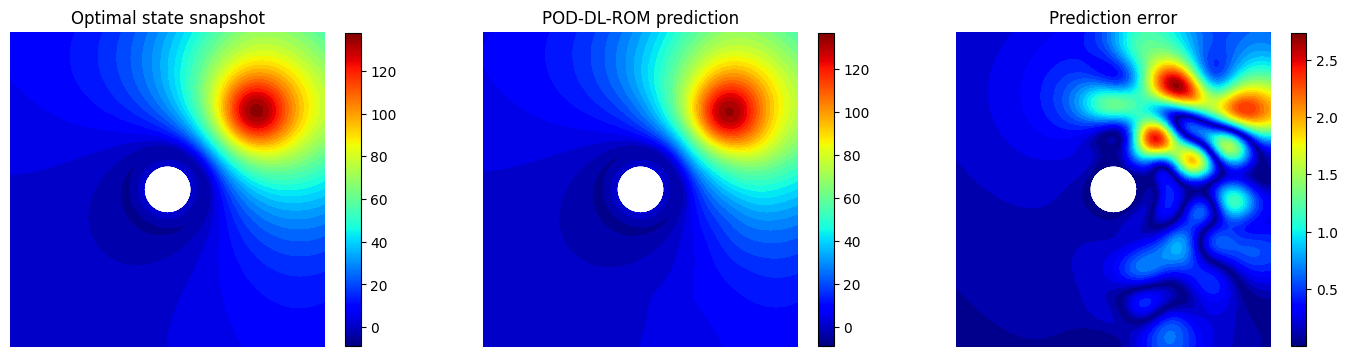

In [28]:
# FOM vs POD-DL-ROM PREDICTION (PLOTS)

which = -1

qmin = min(Q[which].min(), Q_hat[which].min())
qmax = max(Q[which].max(), Q_hat[which].max())

plotlist = [Q[which], Q_hat[which], ((Q[which] - Q_hat[which])**2).sqrt()]
fe.multiplot(plotlist, (10, 10), space, titles = ("Optimal state snapshot", "POD-DL-ROM prediction", "Prediction error"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

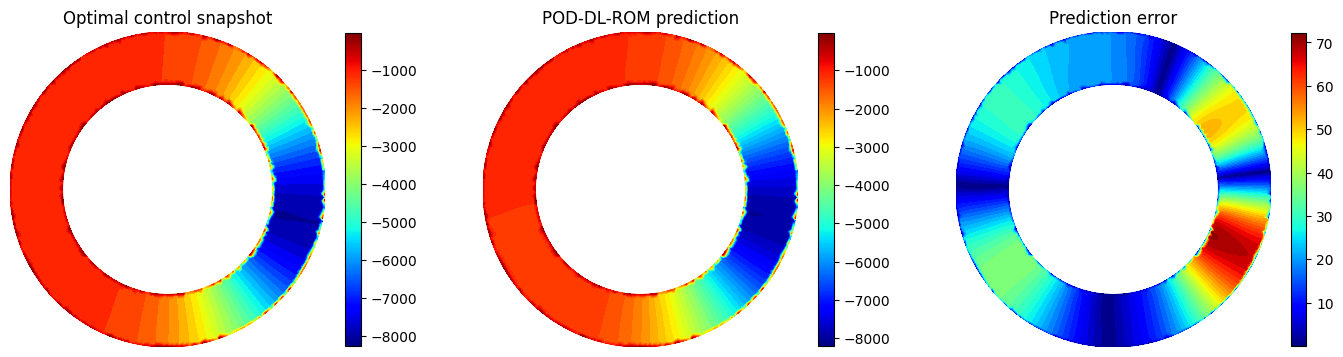

In [29]:
# FOM vs POD-DL-ROM PREDICTION (PLOTS)

which = -1

plotlist = [U[which], U_hat[which], ((U[which] - U_hat[which])**2).sqrt()]
fe.multiplot(plotlist, (10, 10), space_control, titles = ("Optimal control snapshot", "POD-DL-ROM prediction", "Prediction error"), size = 6, cmap = "jet", levelcurves = True, colorbar = True)

# Test case: solve the OCP for different source positions


In [29]:
# CREATE TEST PARAMETERS

dtheta_source_test = 0.05 # Difference between theta_source of consecutive source positions 
npos = round(pi / dtheta_source_test) - 1 # Number of source positions to investigate
r_source_test = 0.65 # Distance between source and obstacle fixed

MU_test = CPU.zeros(npos, nparams)

for j in range(npos):
    MU_test[j,0] = -pi/2 + (j + 1) * float(dtheta_source_test)
    MU_test[j,1] = r_source_test
    clc()

In [32]:
# PREDICT OPTIMAL STATE AND CONTROL

Q_DLROM_test_hat, U_POD_test_hat = ocp.redmap(phi, MU_test, [Q_DLROM, U_POD], minmax = True, training = False, save = False, path = 'NN/Cooling/phi.pt')

Q_test_hat = projectup(pod_Q, decoder(Q_DLROM_test_hat))
U_test_hat = projectup(pod_U, U_POD_test_hat)

In [76]:
# APPLY PREDICTED CONTROL TO THE SYSTEM

Q_test = CPU.zeros(npos, nh)
qobs_test = []
for j in range(npos):
    u = fe.asvector(U_test_hat[j], space_control)
    q = compute_state([MU_test[j,0].item(), MU_test[j,1].item()], u = u)
    Q_test[j] = torch.from_numpy(q.vector()[:])
    qobs_test.append(q.vector()[idx_obstacle].mean())

print(f"Mean obstacle temperature: {sum(qobs_test) / len(qobs_test)}")

Mean obstacle temperature: 0.27906156941921273


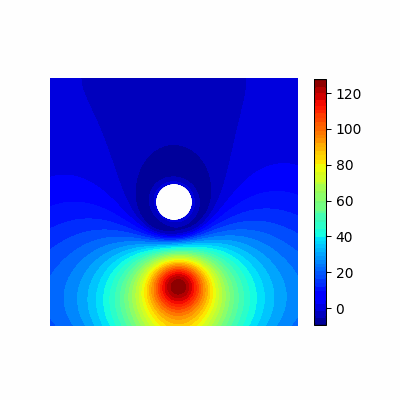

In [55]:
# POD-DL-ROM CONTROLLED STATE (PLOT)

fe.animate(Q_test, space, cmap = "jet", levelcurves = True, colorbar = True)

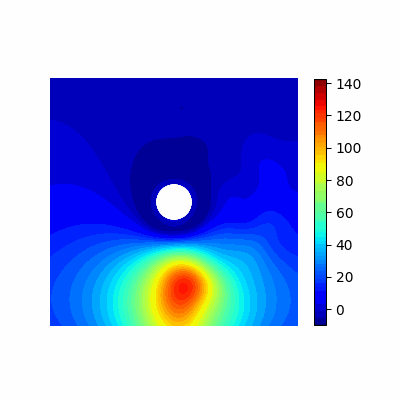

In [33]:
# POD-DL-ROM STATE PREDICTION (PLOT)

fe.animate(Q_test_hat, space, cmap = "jet", levelcurves = True, colorbar = True)

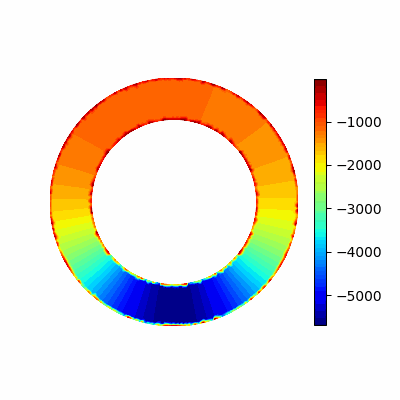

In [34]:
# POD-DL-ROM STATE PREDICTION (PLOT)

fe.animate(U_test_hat, space_control, cmap = "jet", levelcurves = True, colorbar = True)